# COMP3314 - Assignment 1 
created by krohak 2018-02-15

** This notebook contains the implementation of a k-nn classifier from scratch and some experiments with it. **

Let's first import some essential Python libraries we'll use throughout the notebook:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Part 1 - Preprocessing
### Loading the Data

Let's load the data in a Pandas dataframe and have a quick look at it:

In [3]:
wisc_data = pd.read_csv("wisc_bc_data.csv")
wisc_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,87139402,B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,...,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
1,8910251,B,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,...,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
2,905520,B,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,...,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
3,868871,B,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,...,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
4,9012568,B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,...,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


In [4]:
wisc_data.shape

(569, 32)

Lets get rid of the 'id' column of the data since it is unnecessary. 

In [5]:
wisc_data = wisc_data.iloc[:,1:] # get rid of the id

Lets also store the 'diagnosis' column in a separate dataframe since it corresponds to the labels:

In [6]:
labels = wisc_data.iloc[:,0]
wisc_data = wisc_data.iloc[:,1:] # get rid of the labels
labels.head()

0    B
1    B
2    B
3    B
4    B
Name: diagnosis, dtype: object

### Normalization:
We will use two ways to normalize the data:
1. Feature scaling: Making it range from 0-1 for all columns using the max() and min() value
2. Standard score: Using mean() and std() to find out how many standard deviations above the mean a certain value lies

Lets create functions for both types of normalization.

In [7]:
def feature_scalling(dataframe):
    return (dataframe - dataframe.min(0))/ (dataframe.max(0) - dataframe.min(0))

In [8]:
def standard_score(dataframe):
    return (dataframe - dataframe.mean()) / dataframe.std()

Let's visualizing the feature scaled normalized data which should be in the range 0-1

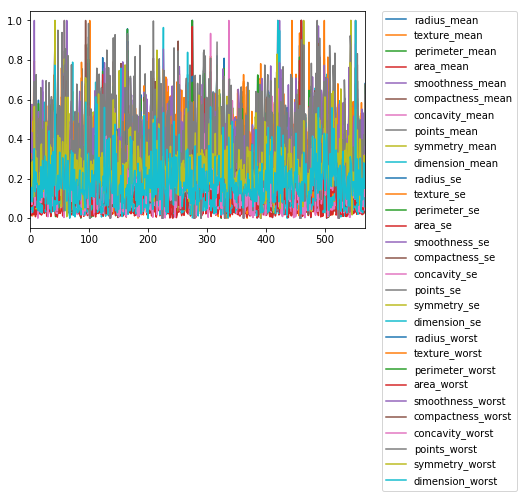

In [9]:
wisc_normalized = feature_scalling(wisc_data)
wisc_normalized.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Visualizing the standard score normalized data:

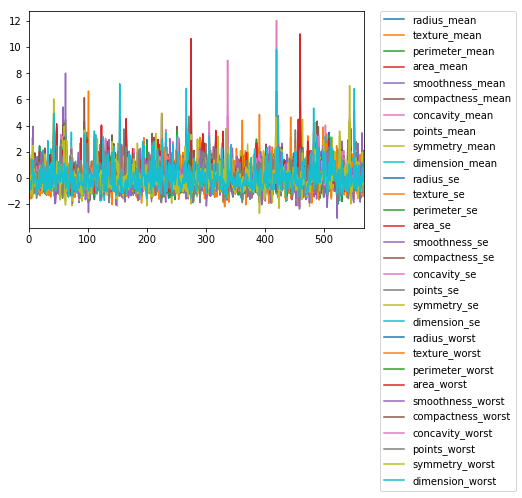

In [10]:
wisc_normalized = standard_score(wisc_data)
wisc_normalized.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We will normalize the data using feature scalling in our initial experiments, thus:

In [11]:
wisc_normalized = feature_scalling(wisc_data)

### Splitting training and testing datasets:

Initially, we split the data from 0-468 for training and the remaining 100 for testing.
We can use `train_test_split()` from `sklearn.cross_validation` to split the testing and training data according to the percentage of the testing data like so:

In [12]:
# `test_size` is the fraction of the data used for testing. 
# Note that instead of passing the entire dataframe, we pass just the values for convenience
X_train, X_test, y_train, y_test = train_test_split(wisc_normalized.values, labels.values, test_size = 0.125, random_state = 0)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((497, 30), (72, 30), (497,), (72,))

## Part 2 - KNN Classifier from scratch
In this part, we create our KNeighboursClassifier class with the `fit()` and `predict()` functions (implementing the interface of scikitlearn's KNeighboursClassifier).

A brief overview of what the functions in `MyKNeighboursClassifier` do:

`fit()` - stores the X_train and y_train values as a part of the class variables.

`uniform_distances()` - For each observation in X_test, calculates its euclidian distance from each value of X_train and sorts in increasing order.

`uniform()` - Counts the labels for all K Nearest Neighbours for a observation in X_test, classifies the observation using the labels of these neighbours and appends into a list of predictions.

`predict()` - Outputs the predictions.

In [14]:
class MyKNeighborsClassifier(object):

    def __init__(self,k=5,weights='uniform'):
        self.k=k
        self.weights=weights

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def uniform(self, X_test):
        distances = self.uniform_distances(self.X_train, X_test)
        y_pred = []
        
        # for all indices of X_test
        for i in range(X_test.shape[0]):
            top_k = []

            # for each k, take its label
            for j in range(self.k):
                top_k.append(distances[i][j][1])
                
            # count the number of labels of each type, take the most common label
            pred = Counter(top_k).most_common(1)[0][0]
            y_pred.append(pred)

        return y_pred

    
    def uniform_distances(self, X_train, X_test):
        distances = []

        # for each node in x_test
        for i in range(X_test.shape[0]):
            euclidian_dist = np.zeros(X_train.shape[0])
            distance_i = []

            # for each node in x_train
            for j in range(X_train.shape[0]):

                # compute the euclidian distance from i to j
                euclidian_dist[j] = np.sqrt(np.sum(np.square(np.array(X_test[i]) - np.array(X_train[j]))))

                # append in distance_i list along with the label of j
                distance_i.append([euclidian_dist[j], self.y_train[j]])

            # sort in decreasing order of distances
            distance_i = sorted(distance_i)
            distances.append(distance_i)

        return distances

    
    def predict(self,X_test):
        return self.uniform(X_test)

Testing its accuracy:

In [15]:
neigh = MyKNeighborsClassifier(k=25)

In [16]:
neigh.fit(X_train,y_train)

In [17]:
y_pred = neigh.predict(X_test)

In [18]:
print(accuracy_score(y_pred , y_test)*100)

91.6666666667


Now we created the weighted version of MyKNeighboursClassifier. We include two new functions:

`weighted_distances()`- Calculates the square of euclidian distances from each observation in X_test to each observation in X_triain and sorts in increasing order of distances.

`distance()`- Converts labels into binary classifications using keys, Weighs each classification according to the inverse of the sqaure distance and outputs the predicted labels.

In [19]:
keys={'M':0,'B':1,0:'M',1:'B'} # for converting the labels into binary classifications and vice-versa

class MyKNeighborsClassifier(object):

    def __init__(self,k=5,weights='uniform'):
        self.k=k
        self.weights=weights
        
    def get_params(self, deep=True):
        return {'k':self.k}
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            print(parameter,value)
            setattr(self, parameter, value)
        return self
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def weighted(self, X_test):
        distances = self.weighted_distances(self.X_train, X_test)
        y_pred = []

        # for all indices of X_test
        for i in range(X_test.shape[0]):
            top_k = []
            k_dist = []

            # for each k
            for j in range(self.k):
                top_k.append(distances[i][j][1])
                
                # we store the inverse distances for the denominator
                k_dist.append(1/distances[i][j][0])
                
            # sum of k labels weighted acording to the inverse of their distances / sum of k inverse distances
            sum_k = np.zeros(1)
            try:
                sum_k = sum(top_k)/sum(k_dist)
            except:
                pass
            
            # round off to classify between 0 to 1 and convert back to M or B
            y_pred.append(keys[sum_k.round()])

        return y_pred
    

    def weighted_distances(self, X_train, X_test):
        distances = []

        # for each node in x_test
        for i in range(X_test.shape[0]):
            euclidian_dist_sq = np.zeros(X_train.shape[0])
            distance_i = []

            # for each node in x_train
            for j in range(X_train.shape[0]):

                # compute the square of the euclidian distance from i to j
                euclidian_dist_sq[j] = np.sum(np.square(np.array(X_test[i]) - np.array(X_train[j])))

                # calculate the label weight by converting j's label into binary classification
                # and multiplying with inverse of the distance from i to j
                label_weight = keys[self.y_train[j]]/euclidian_dist_sq[j]
                
                # append in distance_i list 
                distance_i.append([euclidian_dist_sq[j], label_weight])
                
            # sort in decreasing order of distances and append
            distances.append(sorted(distance_i))

        return distances
  

    def uniform(self, X_test):
        distances = self.uniform_distances(self.X_train, X_test)
        y_pred = []       
        for i in range(X_test.shape[0]):
            top_k = []
            for j in range(self.k):
                top_k.append(distances[i][j][1])
            pred = Counter(top_k).most_common(1)[0][0]
            y_pred.append(pred)
        return y_pred
    
    def uniform_distances(self, X_train, X_test):
        distances = []
        for i in range(X_test.shape[0]):
            euclidian_dist = np.zeros(X_train.shape[0])
            distance_i = []
            for j in range(X_train.shape[0]):
                euclidian_dist[j] = np.sqrt(np.sum(np.square(np.array(X_test[i]) - np.array(X_train[j]))))
                distance_i.append([euclidian_dist[j], self.y_train[j]])
            distance_i = sorted(distance_i)
            distances.append(distance_i)
        return distances
    
    def predict(self,X_test):
        if self.weights == 'distance':
            return self.weighted(X_test)
        return self.uniform(X_test)

Testing its accuracy:

In [20]:
neigh = MyKNeighborsClassifier(k=25,weights='distance')
neigh.fit(X_train,y_train)
y_pred = neigh.predict(X_test)
print(accuracy_score(y_pred , y_test)*100)

94.4444444444


Improvement!

## Part 3 - Visualization

In the most basic visualization, we can plot each observation's true binary label and compare it with the predicted binary label. We can see below that some crosses do not align with the dots.

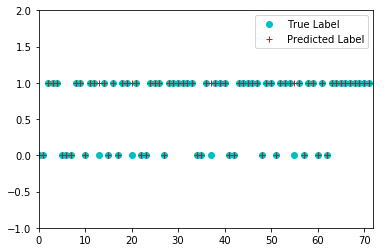

In [21]:
plt.plot([i for i in range(X_test.shape[0])], [keys[x] for x in y_test], "co")
plt.plot([i for i in range(X_test.shape[0])], [keys[x] for x in y_pred] ,"r+")
plt.axis([0,X_test.shape[0],-1,+2])
plt.legend(labels=['True Label','Predicted Label'])
plt.show()

We can also compare the True Labels and Predicted Labels using a pie chart. The outer ring corresponds to the True Labels and inner one corresponds to the Predicted Labels, as show in the legend:

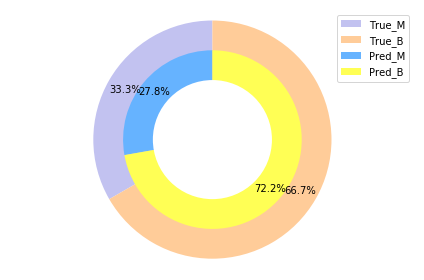

In [22]:
labels1 = 'True_M', 'True_B'
counts1 = Counter(y_test)
sizes1 = [counts1['M'], counts1['B']]


labels2 = 'Pred_M', 'Pred_B'
counts2 = Counter(y_pred)
sizes2 = [counts2['M'], counts2['B']]

colors1 = ['#c2c2f0','#ffcc99']
colors2 = ['#66b3ff','#ffff55']

explode = (0.2,0.2) 

plt.pie(sizes1, autopct='%1.1f%%', colors=colors1, pctdistance=0.85, startangle=90, frame=True)
plt.pie(sizes2, autopct='%1.1f%%', colors=colors2, pctdistance=0.85, radius=0.75, startangle=90)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.legend(labels = labels1 + labels2)
plt.show()

However, the most insightful way to visualize our predicted classifications would be if we get to know the proportion of True Positives and True Negatives in our Predicted Labels. So we write a function for the same:

In [23]:
def true_proportion_pie(y_pred,y_test):
    
    B_fake = 0
    M_fake = 0

    for i,y in enumerate(y_test):
        if y=='M' and y_pred[i]=='B':
            B_fake+=1
        elif y=='B' and y_pred[i]=='M':
            M_fake+=1

    counts2 = Counter(y_pred)        
    B_real = counts2['B'] - B_fake
    M_real = counts2['M'] - M_fake

    labels1 = 'Pred_M', 'Pred_B'
    counts1 = Counter(y_test)
    sizes1 = [counts2['M'], counts2['B']]

    explode1 = (0,0)

    labels2 = 'True Positive', 'False Positive', 'True Negative', 'False Negative'
    counts2 = Counter(y_pred)
    sizes2 = [M_real,M_fake,B_real,B_fake]

    explode2 = (0,0,0,0)

    colors1 = ['#66b3ff','#ffff55']
    colors2 = ['#aaff77','#ff6666']

    plt.pie(sizes1, autopct='%1.1f%%', colors=colors1, explode=explode1, pctdistance=1.1, startangle=90, frame=True)
    plt.pie(sizes2, autopct='%1.1f%%', colors=colors2, explode=explode2, pctdistance=0.65, radius=0.75, startangle=90)
    centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.axis('equal')
    plt.tight_layout()
    plt.legend(labels = labels1 + labels2)
    plt.show()

Calling the function on our predicted and test labels:

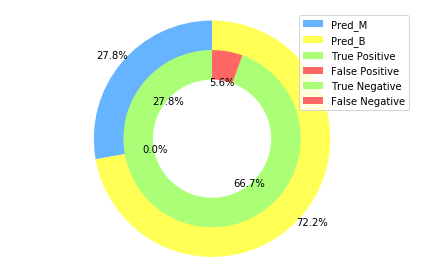

In [24]:
true_proportion_pie(y_pred,y_test)

## Part 4 - Experiments and Comparison of accuracies

We can now experiment different k values and different splits of the dataset to compare the accuracies. We define a function which takes allocations for k and percentage of test size like so:

In [25]:
def predict_func(allocs,pie=False):
    X_train, X_test, y_train, y_test = train_test_split(wisc_normalized.values, 
                                                        labels.values, test_size = (allocs[1]/100), random_state = 0)
    neigh = MyKNeighborsClassifier(k=int(allocs[0]),weights='distance')
    neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    
    if pie:
        true_proportion_pie(y_pred,y_test)
    
    print (accuracy_score(y_pred , y_test)*100)

In [26]:
predict_func([25,12.5])

94.4444444444


We can randomly try to compare a few pairs of k and test size percentages:

95.8333333333
95.8333333333
96.1240310078


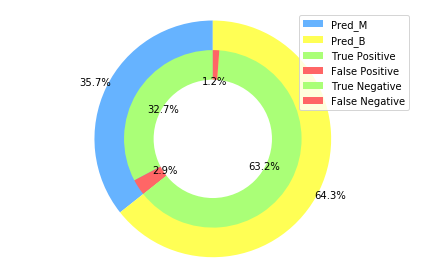

95.9064327485


In [27]:
predict_func([5,12.5])
predict_func([15,12.5])
predict_func([5,22.5])
predict_func([5,30],pie=True)

Or, we can feed our function to a [Scipy Optimizer](https://docs.scipy.org/doc/scipy/reference/optimize.html), which finds the minima for a given function. 

Lets define our function, which will take a set of allocations for K and percentage of test size as input. It will output negative of the accuracy score given to the model, since we want to minimize the negative of accuracy score.

In [28]:
def error_func(allocs):
    print(allocs)
    allocs = allocs.reshape((-1,1))
    X_train, X_test, y_train, y_test = train_test_split(wisc_normalized.values, 
                                                        labels.values, test_size = (allocs[1]/100), random_state = 0)
    neigh = MyKNeighborsClassifier(k=int(allocs[0]),weights='distance')
    neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    return -(accuracy_score(y_pred , y_test)*100)

We use [Basin-hopping](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.basinhopping.html), which is a stochastic algorithm which attempts to find the global minimum of a smooth scalar function of one or more variables.

In [29]:
import scipy.optimize as spo
result = spo.basinhopping(error_func,[5,30], T=1.0, stepsize=1,minimizer_kwargs={'method':'SLSQP','bounds':((1,15),(10,50)), 'options':{'disp':True,'eps' : 1e0}},interval=1,niter_success=5,disp=True)

[  5.  30.]
[  5.  30.]
[  6.  30.]
[  5.  31.]
[  6.16959064  30.13876499]
[  6.16959064  30.13876499]
[  7.16959064  30.13876499]
[  6.16959064  31.13876499]
[  5.39486496  30.17355401]
[  5.93399297  30.14934449]
[  6.13181347  30.14046137]
[  6.15070206  30.13961318]
[  6.16014635  30.13918909]
[  6.1648685   30.13897704]
[  6.16722957  30.13887102]
[  6.16841011  30.138818  ]
[  6.16900037  30.1387915 ]
[  6.16929551  30.13877824]
[  6.16944308  30.13877162]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -97.09302325581395
            Iterations: 2
            Function evaluations: 19
            Gradient evaluations: 2
basinhopping step 0: f -97.093
adaptive stepsize: acceptance rate 0.000000 target 0.500000 new stepsize 0.9 old stepsize 1
[  6.64849297  29.802593  ]
[  6.64849297  29.802593  ]
[  7.64849297  29.802593  ]
[  6.64849297  30.802593  ]
[  4.2955518   29.90286038]
[  4.2955518   29.90286038]
[  5.2955518   29.90286038]
[  4

[  4.40945906  33.19110307]
[  4.40945906  33.19110307]
[  5.40945906  33.19110307]
[  4.40945906  34.19110307]
[  3.70507246  33.20782772]
[  4.20343165  33.1959949 ]
[  4.30644535  33.19354898]
[  4.3579522   33.19232603]
[  4.38370563  33.19171455]
[  4.39658234  33.19140881]
[  4.4030207   33.19125594]
[  4.40623988  33.19117951]
[  4.40784947  33.19114129]
[  4.40865426  33.19112218]
[  4.40905666  33.19111263]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.4126984126984
            Iterations: 2
            Function evaluations: 19
            Gradient evaluations: 2
basinhopping step 9: f -98.4127 trial_f -98.4127 accepted 1  lowest_f -98.4127
found new global minimum on step 9 with function value -98.4127
adaptive stepsize: acceptance rate 0.900000 target 0.500000 new stepsize 1.88168 old stepsize 1.69351
[  4.47316615  31.76438557]
[  4.47316615  31.76438557]
[  5.47316615  31.76438557]
[  4.47316615  32.76438557]
[  2.26322139  

In [30]:
print(result.x,result.fun)

[  4.40905666  33.19111263] -98.4126984126984


We found the minima at the above allocations for k and test_size. Finally, let's visualize this:

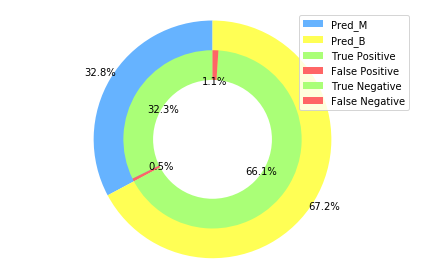

98.4126984127


In [31]:
predict_func(result.x,pie=True)